# Section 4.2.2. VAE Implementation

In [1]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import *

torch.manual_seed(0)

In [2]:
# -------------------------------
# Define the VAE model
# -------------------------------
class VAE(nn.Module):
    def __init__(self, z_dim, input_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim

        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(input_dim, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.enc_fc_mu = nn.Linear(128 * 8 * 8, z_dim)
        self.enc_fc_logvar = nn.Linear(128 * 8 * 8, z_dim)

        # Decoder
        self.dec_fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8),
            nn.ReLU(True)
        )
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, input_dim, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.enc_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.dec_fc(z)
        z = z.view(z.size(0), 128, 8, 8)
        z = self.dec_conv(z)
        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

## 1. Training Stage

In [ ]:
# -------------------------------
# Loss function
# -------------------------------
def loss_fn(recon_x, x, mu, logvar):
    """
    MSE based reconstruction loss and KL divergence loss for VAE.
    KL divergence between the latent distribution and the standard normal distribution.
    """
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# -------------------------------
# Training
# -------------------------------
def train_vae_model(model, dataloader, optimizer, num_epochs, device):
    model.train()
    total_samples = len(dataloader.dataset)
    for epoch in range(num_epochs):
        train_loss = 0.0
        for data in dataloader:
            optimizer.zero_grad()
            data = data.to(device)
            batch_size = data.size(0)
            recon_data, mu, logvar = model(data)
            loss = loss_fn(recon_data, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
        avg_loss = train_loss / total_samples
        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:02}/{num_epochs}], Loss: {avg_loss:>11.4f}")
    return model

![alt text](img/VAE_edit.png "Title")

The loss is defined as

- $ \begin{align} \mathcal{L}(\mathbf{x};\theta,\phi) &=  \mathbb{E}_{\mathbf{z} \sim q_{\phi} (\mathbf{z} | \mathbf{x})} \left[ \log p_{\theta}(\mathbf{x}|\mathbf{z})  \right]- D_{KL} \left( q_{\phi} \left(\mathbf{z}|\mathbf{x} \right) || p (\mathbf{z})  \right) \\ &= \text{Reconstruction Loss + Regularization} \end{align} $

The equation is simplified as

- $D_{KL}(\mathcal N_1({\mu_1, \sigma_1}^2)) || \mathcal N_2({\mu_2, \sigma_2}^2))=\log {\frac{\sigma_2}{\sigma_1}}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-{1\over 2}$
- $D_{KL}(\mathcal N_1({\mu_1, \sigma_1}^2))||\mathcal N(0, 1))=- \frac{1}{2}\left(1 + 2\log \sigma_1- \mu_1^2 -\sigma_1^2   \right)$

In [ ]:
data_path = '../dataset/i24_normalized.pt' 
batch_size = 250
num_epochs = 50
z_dim = 64
lr = 0.0005
beta1 = 0.8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset, data_loader = load_and_preprocess_data(data_path, batch_size)

input_dim = dataset.shape[1]  # dataset.shape: (40000, 1, 64, 64) → input_dim = 1

model = VAE(z_dim, input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.98))

In [ ]:
print("VAE summary:")
summary(model, (input_dim, 64, 64))

In [ ]:
model = train_vae_model(model, data_loader, optimizer, num_epochs, device)

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/vae_model.pth")
print("VAE model saved.")

## 2. Testing Stage

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_generated_samples(model, z_dim, device, save_path, model_name,
                                real_images, nrows=8, ncols=8):
    model.eval()
    with torch.no_grad():
        z_600 = torch.randn(600, z_dim).to(device)
        samples_600 = model.decode(z_600).cpu().numpy()
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 8))
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            ax[i, j].imshow(samples_600[idx][0, :, :], origin="lower", cmap="viridis")
            ax[i, j].axis("off")
    plt.suptitle("Generated Samples", fontsize=16)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=500)
    plt.show()
    plt.close()

    if real_images is not None:
        if samples_600.shape[1] == 1:
            generated_images = samples_600[:, 0, :, :]
        else:
            generated_images = np.mean(samples_600, axis=1)
        mse_score = evaluate_mse(real_images, generated_images, [2])
        print(f"MSE: {mse_score}")
        
        lpips_score = evaluate_lpips(real_images, generated_images, device, match_mode="best_match")
        print(f"LPIPS: {lpips_score:.8f}")
        
        sobel_mse = evaluate_sobel_edge_mse(real_images, generated_images, match_mode="best_match")
        print(f"Sobel-Edge-MSE: {sobel_mse:.8f}")
    
    return None

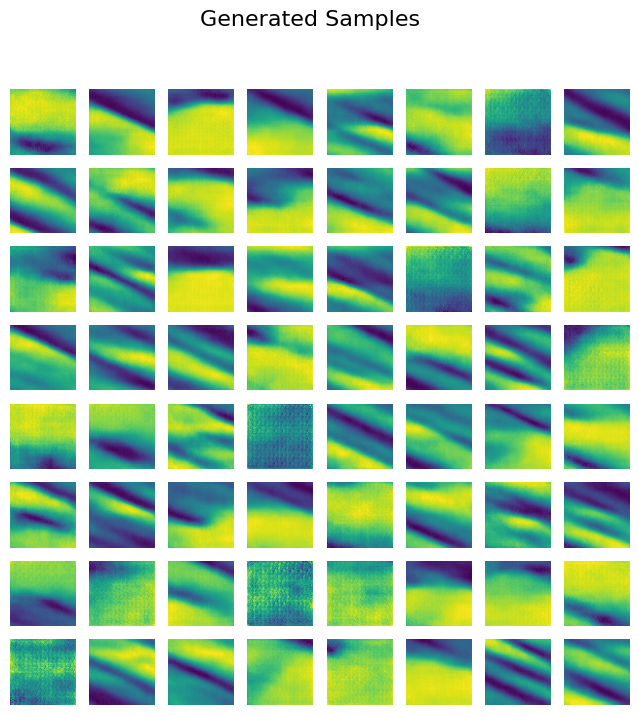

MSE: {2: {'mse': 0.06645502}}
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS: 0.38956512
Sobel-Edge-MSE: 0.00169295


In [4]:
# Can use CPU in the inference, but highly recommended to use GPU
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = '../dataset/i24_normalized.pt' 
dataset = torch.load(data_path)
input_dim = dataset.shape[1]
real_images = dataset[:600].squeeze(1).numpy()

z_dim = 64

model = VAE(z_dim, input_dim).to(device)
model.load_state_dict(torch.load("models/vae_model.pth", map_location=device))
model.eval()

os.makedirs("img", exist_ok=True)

evaluation_results = visualize_generated_samples(model, z_dim, device,
                                                 save_path="img/VAE_result.png",
                                                 model_name="VAE",
                                                 real_images=real_images)
